# AlphaZero FJSP Training

Training notebook for the AlphaZero-based FJSP scheduler.
Designed to run with GPU support.

In [1]:
import sys
import os
from pathlib import Path

# Find project root by searching upward, fallback to hardcoded path
_cwd = Path().resolve()
project_root = None
for parent in [_cwd] + list(_cwd.parents):
    if (parent / "utils" / "input_schemas.py").exists():
        project_root = str(parent)
        break

if project_root is None:
    # Hardcoded fallback for supercomputer
    project_root = "/home/ad.msoe.edu/weinbendera/FJSSP-MCTS-Research"

if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import numpy as np

print(f"Project root: {project_root}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

Project root: C:\Users\weinbendera\Repos\FJSSP Research\FJSSP-MCTS-Research
PyTorch version: 2.10.0+cpu
CUDA available: False


## Load Configuration

In [ ]:
import json

data_path = os.path.join(project_root, "data", "Input_JSON_Schedule_Optimization.json")
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
from utils.input_schemas import ProductRequest

# product_requests = [
#     ProductRequest(product='WOVEN LABEL OURELA FABRIC', amount=25, deadline=None),
#     ProductRequest(product='ESTORE RIBBON', amount=10, deadline=None),
#     ProductRequest(product='GORGORÃO RIBBON', amount=1, deadline=None),
#     ProductRequest(product='TAFFETA EMBLEM', amount=1, deadline=None),
#     ProductRequest(product='PRINTED RIBBON', amount=1, deadline=None),
#     ProductRequest(product='ROK ELASTIC', amount=3, deadline=None),
#     ProductRequest(product='BRAIDED ELASTIC', amount=1, deadline=None),
#     ProductRequest(product='SMOOTH ELASTIC(A)', amount=1, deadline=None),
#     ProductRequest(product='STRAP W/ STRIPES', amount=0, deadline=None),
# ]

# use input data from json file
product_requests_data = data["product_requests"]
product_requests = [ProductRequest(**pr) for pr in product_requests_data]
product_requests

[ProductRequest(product='WOVEN LABEL OURELA FABRIC', amount=13, deadline=None),
 ProductRequest(product='ESTORE RIBBON', amount=6, deadline=None),
 ProductRequest(product='WOVEN LABEL OURELA CUT', amount=5, deadline=None),
 ProductRequest(product='GORGORÃO RIBBON', amount=13, deadline=None),
 ProductRequest(product='GORGORÃO RIBBON W/ INSCR', amount=5, deadline=None),
 ProductRequest(product='TAFFETA EMBLEM', amount=10, deadline=None),
 ProductRequest(product='PRINTED RIBBON', amount=30, deadline=None),
 ProductRequest(product='ELASTIC W/ INSCR', amount=2, deadline=None),
 ProductRequest(product='ELASTIC W/ INSCR', amount=1, deadline=960),
 ProductRequest(product='ROK ELASTIC', amount=3, deadline=None),
 ProductRequest(product='SMOOTH STRAP(A)', amount=4, deadline=None),
 ProductRequest(product='BRAIDED ELASTIC', amount=15, deadline=None),
 ProductRequest(product='PRINTED RIBBON  PES', amount=10, deadline=None),
 ProductRequest(product='SMOOTH ELASTIC(A)', amount=5, deadline=None),
 Pr

In [4]:
from utils.factory_logic_loader import FactoryLogicLoader
from utils.input_schemas import ProductRequest

# Load factory logic
factory_logic = FactoryLogicLoader.load_from_file(data_path)


product_requests = [
    ProductRequest(**pr) for pr in data['product_requests']
]

print(f"Products: {len(factory_logic.products)}")
print(f"Machines: {len(factory_logic.machines)}")
print(f"Tasks: {len(factory_logic.tasks)}")
print(f"Task modes: {len(factory_logic.task_modes)}")
print(f"Product requests: {len(product_requests)}, total units: {sum(pr.amount for pr in product_requests)}")

Products: 14
Machines: 3
Tasks: 7
Task modes: 13
Product requests: 15, total units: 132


## Compile Config & Verify

In [5]:
from utils.job_builder import JobBuilder
from schedulers.alphazero.env.config_compiler import CompiledConfig

jobs = JobBuilder(factory_logic).build_jobs(product_requests)
config = CompiledConfig.compile(factory_logic, jobs)

print(f"Operations: {config.num_ops}")
print(f"Jobs: {config.num_jobs}")
print(f"Machines: {config.num_machines}")
print(f"Task modes: {config.num_task_modes}")
print(f"Action triples: {config.num_actions}")
print(f"Precedence pairs: {config.precedence_pairs.shape[0]}")
print(f"Collision pairs: {config.collision_pairs.shape[0]}")
print(f"Time leaps: {config.time_leaps}")

Operations: 275
Jobs: 132
Machines: 3
Task modes: 13
Action triples: 517
Precedence pairs: 3
Collision pairs: 1
Time leaps: [192 384 576 768 960]


## Quick Environment Test

In [6]:
from schedulers.alphazero.env.fjsp_env import FJSPEnv, COMPLETED

env = FJSPEnv(config)
env.reset()

# Run with random legal actions
steps = 0
while not env.done:
    legal = env.get_legal_actions()
    legal_indices = np.where(legal)[0]
    action = np.random.choice(legal_indices)
    reward, done = env.step(action)
    steps += 1

print(f"Episode complete in {steps} steps")
print(f"All ops completed: {np.all(env.op_status == COMPLETED)}")
print(f"Makespan: {env.get_makespan()}")
print(f"Final reward: {reward}")

Episode complete in 2604 steps
All ops completed: True
Makespan: 868
Final reward: -868.0


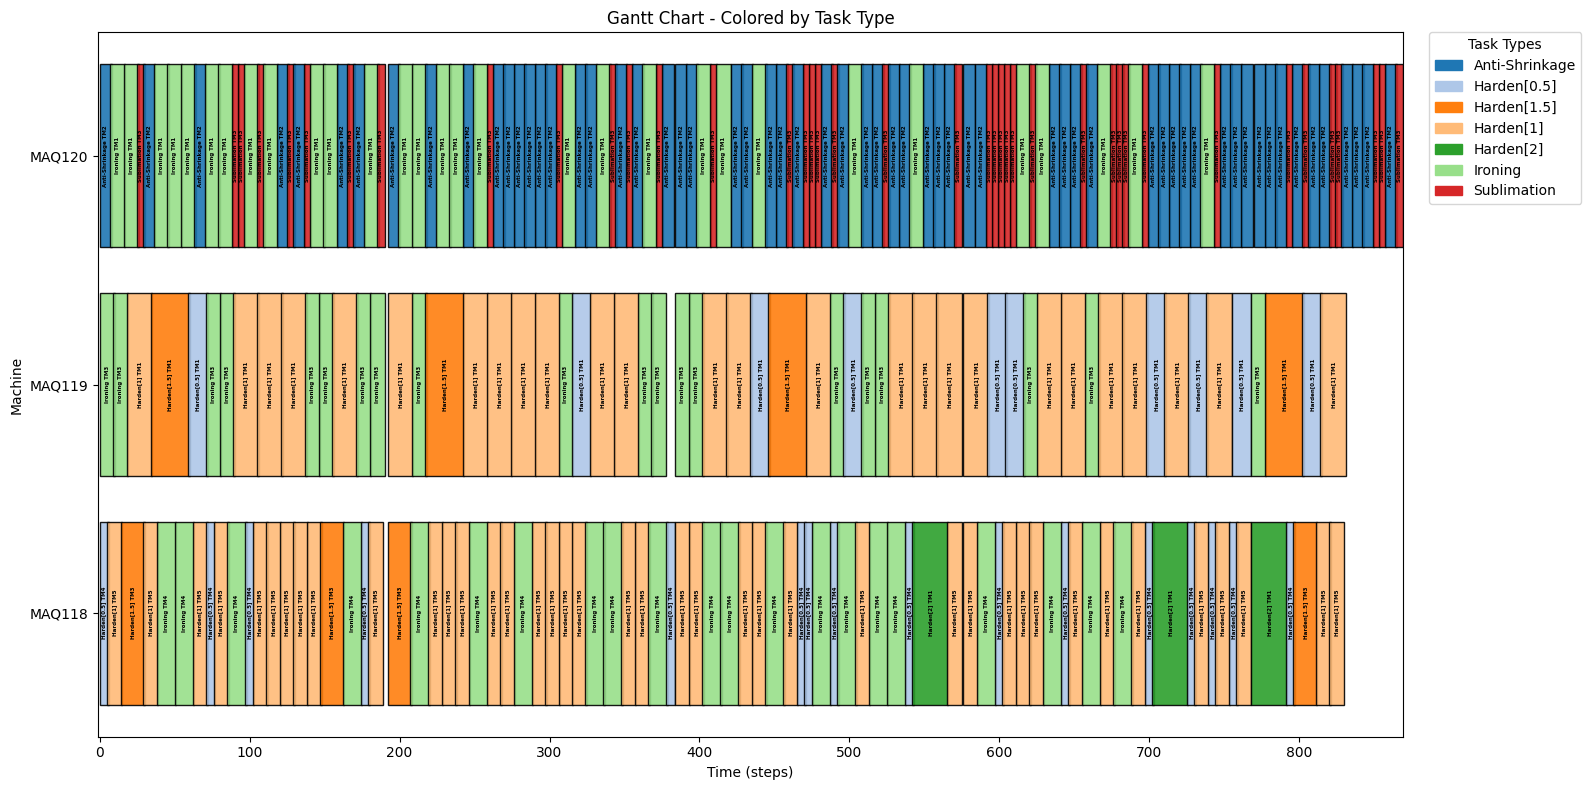

In [7]:
from schedulers.scheduler import ScheduledOperation, Schedule

# Build Schedule from completed env state
scheduled_ops = []
for op_idx in range(config.num_ops):
    m_idx = int(env.op_assigned_machine[op_idx])
    tm_idx = int(env.op_assigned_task_mode[op_idx])
    start = int(env.op_start_step[op_idx])
    # Look up duration from action table
    match = np.where(
        (config.action_op == op_idx) &
        (config.action_machine == m_idx) &
        (config.action_task_mode == tm_idx)
    )[0]
    duration = int(config.action_duration[match[0]])

    scheduled_ops.append(ScheduledOperation(
        operation_id=config.op_ids[op_idx],
        job_id=config.job_ids[int(config.op_to_job[op_idx])],
        task_id=config.op_task_ids[op_idx],
        machine_id=config.machine_ids[m_idx],
        task_mode_id=config.task_mode_ids[tm_idx],
        start_step=start,
        end_step=start + duration,
    ))

schedule = Schedule(operations=scheduled_ops, makespan=env.get_makespan())
img = schedule.plot_gantt_by_task()
if img:
    display(img)

In [8]:
import pandas as pd

# Build dataframe of all scheduled operations
rows = []
for op in schedule.operations:
    rows.append({
        "machine": op.machine_id,
        "operation": op.operation_id,
        "task": op.task_id,
        "task_mode": op.task_mode_id,
        "start": op.start_step,
        "end": op.end_step,
        "duration": op.end_step - op.start_step,
    })

df = pd.DataFrame(rows).sort_values(["machine", "start"]).reset_index(drop=True)

# Check for overlaps per machine
overlaps = []
for machine_id, group in df.groupby("machine"):
    ops = group.sort_values("start")
    for i in range(len(ops) - 1):
        curr = ops.iloc[i]
        nxt = ops.iloc[i + 1]
        if curr["end"] > nxt["start"]:
            overlaps.append({
                "machine": machine_id,
                "op_a": curr["operation"],
                "end_a": curr["end"],
                "op_b": nxt["operation"],
                "start_b": nxt["start"],
                "overlap": curr["end"] - nxt["start"],
            })

if overlaps:
    print(f"OVERLAPS FOUND: {len(overlaps)}")
    display(pd.DataFrame(overlaps))
else:
    print("No overlaps found!")

# Show per-machine operation table
for machine_id in sorted(df["machine"].unique()):
    m_df = df[df["machine"] == machine_id][["operation", "task", "task_mode", "start", "end", "duration"]]
    print(f"\n--- {machine_id} ({len(m_df)} ops) ---")
    display(m_df)

No overlaps found!

--- MAQ118 (84 ops) ---


,operation,task,task_mode,start,end,duration
0,J_WOVEN LABEL OURELA CUT_No Deadline_0005#HARD...,Harden[0.5],Harden[0.5] TM4,0,5,5
1,J_STRAP W/ STRIPES_No Deadline_0005#HARDEN[1]#...,Harden[1],Harden[1] TM5,5,14,9
2,J_WOVEN LABEL OURELA CUT_No Deadline_0001#HARD...,Harden[1.5],Harden[1.5] TM3,14,29,15
3,J_STRAP W/ STRIPES_No Deadline_0006#HARDEN[1]#...,Harden[1],Harden[1] TM5,29,38,9
4,J_WOVEN LABEL OURELA FABRIC_No Deadline_0008#I...,Ironing,Ironing TM4,38,50,12
...,...,...,...,...,...,...
79,J_ROK ELASTIC_No Deadline_0002#HARDEN[2]#0001,Harden[2],Harden[2] TM1,768,791,23
80,J_WOVEN LABEL OURELA FABRIC_No Deadline_0006#H...,Harden[0.5],Harden[0.5] TM4,791,796,5
81,J_WOVEN LABEL OURELA CUT_No Deadline_0002#HARD...,Harden[1.5],Harden[1.5] TM3,796,811,15
82,J_TAFFETA EMBLEM_No Deadline_0002#HARDEN[1]#0001,Harden[1],Harden[1] TM5,811,820,9



--- MAQ119 (60 ops) ---


,operation,task,task_mode,start,end,duration
84,J_WOVEN LABEL OURELA CUT_No Deadline_0001#IRON...,Ironing,Ironing TM3,0,9,9
85,J_GORGORÃO RIBBON_No Deadline_0007#IRONING#0001,Ironing,Ironing TM3,9,18,9
86,J_WOVEN LABEL OURELA FABRIC_No Deadline_0008#H...,Harden[1],Harden[1] TM1,18,34,16
87,J_ROK ELASTIC_No Deadline_0003#HARDEN[1.5]#0001,Harden[1.5],Harden[1.5] TM1,34,59,25
88,J_WOVEN LABEL OURELA FABRIC_No Deadline_0010#H...,Harden[0.5],Harden[0.5] TM1,59,71,12
89,J_WOVEN LABEL OURELA FABRIC_No Deadline_0006#I...,Ironing,Ironing TM3,71,80,9
90,J_WOVEN LABEL OURELA FABRIC_No Deadline_0010#I...,Ironing,Ironing TM3,80,89,9
91,J_STRAP W/ STRIPES_No Deadline_0009#HARDEN[1]#...,Harden[1],Harden[1] TM1,89,105,16
92,J_WOVEN LABEL OURELA FABRIC_No Deadline_0008#H...,Harden[1],Harden[1] TM1,105,121,16
93,J_STRAP W/ STRIPES_No Deadline_0006#HARDEN[1]#...,Harden[1],Harden[1] TM1,121,137,16



--- MAQ120 (131 ops) ---


,operation,task,task_mode,start,end,duration
144,J_STRAP W/ STRIPES_No Deadline_0001#ANTI-SHRIN...,Anti-Shrinkage,Anti-Shrinkage TM2,0,7,7
145,J_GORGORÃO RIBBON_No Deadline_0013#IRONING#0001,Ironing,Ironing TM1,7,16,9
146,J_GORGORÃO RIBBON_No Deadline_0001#IRONING#0001,Ironing,Ironing TM1,16,25,9
147,J_PRINTED RIBBON_No Deadline_0002#SUBLIMATION#...,Sublimation,Sublimation TM3,25,29,4
148,J_PRINTED RIBBON_No Deadline_0022#ANTI-SHRINKA...,Anti-Shrinkage,Anti-Shrinkage TM2,29,36,7
...,...,...,...,...,...,...
270,J_STRAP W/ STRIPES_No Deadline_0006#ANTI-SHRIN...,Anti-Shrinkage,Anti-Shrinkage TM2,842,849,7
271,J_PRINTED RIBBON_No Deadline_0023#SUBLIMATION#...,Sublimation,Sublimation TM3,849,853,4
272,J_PRINTED RIBBON_No Deadline_0013#SUBLIMATION#...,Sublimation,Sublimation TM3,853,857,4
273,J_STRAP W/ STRIPES_No Deadline_0005#ANTI-SHRIN...,Anti-Shrinkage,Anti-Shrinkage TM2,857,864,7


## get_state/set_state Verification

In [9]:
# Fuzz test: save state, take random actions, restore, take same actions, verify identical
env.reset()
np.random.seed(42)

# Take some random steps
for _ in range(20):
    legal = env.get_legal_actions()
    action = np.random.choice(np.where(legal)[0])
    env.step(action)

# Save state
saved_state = env.get_state()

# Take more random steps and record them
np.random.seed(123)
actions_taken = []
states_after = []
for _ in range(10):
    if env.done:
        break
    legal = env.get_legal_actions()
    action = np.random.choice(np.where(legal)[0])
    actions_taken.append(action)
    env.step(action)
    states_after.append(env.get_state())

# Restore and replay
env.set_state(saved_state)
for i, action in enumerate(actions_taken):
    env.step(action)
    replay_state = env.get_state()
    assert np.array_equal(replay_state.op_status, states_after[i].op_status), f"op_status mismatch at step {i}"
    assert np.array_equal(replay_state.machine_busy, states_after[i].machine_busy), f"machine_busy mismatch at step {i}"
    assert replay_state.current_time == states_after[i].current_time, f"current_time mismatch at step {i}"

print("get_state/set_state round-trip test PASSED!")

get_state/set_state round-trip test PASSED!


## Train

In [10]:
from schedulers.alphazero.training.pipeline import AlphaZeroPipeline, PipelineConfig

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")

pipeline_config = PipelineConfig(
    num_iterations=100,
    games_per_iteration=50,
    mcts_simulations=100,
    batch_size=32,
    batches_per_iteration=10,
    hidden_dim=64,
    num_gnn_layers=3,
    checkpoint_interval=10,
    checkpoint_dir=os.path.join(project_root, 'schedulers', 'alphazero', 'checkpoints'),
)

pipeline = AlphaZeroPipeline(
    factory_logic=factory_logic,
    product_requests=product_requests,
    pipeline_config=pipeline_config,
    device=device,
)

history = pipeline.run(verbose=True)

Training on: cpu


KeyboardInterrupt: 

## Training Curves

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

iters = [h['iteration'] for h in history]

axes[0].plot(iters, [h['mean_reward'] for h in history], label='Mean')
axes[0].plot(iters, [h['best_reward'] for h in history], label='Best', alpha=0.7)
axes[0].set_title('Reward (negative makespan)')
axes[0].set_xlabel('Iteration')
axes[0].legend()

axes[1].plot(iters, [h['policy_loss'] for h in history], label='Policy')
axes[1].plot(iters, [h['value_loss'] for h in history], label='Value')
axes[1].set_title('Loss')
axes[1].set_xlabel('Iteration')
axes[1].legend()

axes[2].plot(iters, [h['time'] for h in history])
axes[2].set_title('Time per iteration (s)')
axes[2].set_xlabel('Iteration')

plt.tight_layout()
plt.show()